In [1]:
import os
import time

from tqdm import tqdm
import numpy as np
import wandb
import torch
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms

from my_utils import data, models
from my_utils.utils import Hook, load_model, get_conv_weights, get_feature_maps
from my_utils.vis import vis_4D, sim_matrix


# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:3" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:3 now!


In [3]:
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'
T = transforms.Compose([
    transforms.ToTensor()
])
vis_data = data.MyDataset(os.path.join(Dataset_DIR, 'vis'), transform=T)
vis_loader = DataLoader(vis_data, batch_size=len(vis_data))

In [4]:
imgs, labels = next(iter(vis_loader))
print(imgs.shape)
print(labels)

torch.Size([8, 1, 64, 64])
tensor([0, 0, 1, 1, 2, 2, 3, 3])


In [13]:
ckpt_name = 'best'
model = load_model(run_name='2022_06_06_06_51_25',
                   log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                   ckpt_name=ckpt_name).to(device)
conv_weights = get_conv_weights(model)
print(conv_weights[0].shape)

Loading model parameters ...
best val acc is: 0.9337500333786011
Successfully load model parameters!
(2, 1, 7, 7)


In [5]:
conv_weights = get_conv_weights(model)
conv_weights[-1].transpose(1,0,2,3).shape

(4, 8, 9, 9)

In [6]:
array = sim_matrix(data=conv_weights[3].transpose(1,0,2,3), title=ckpt_name, return_mode='fig_array')

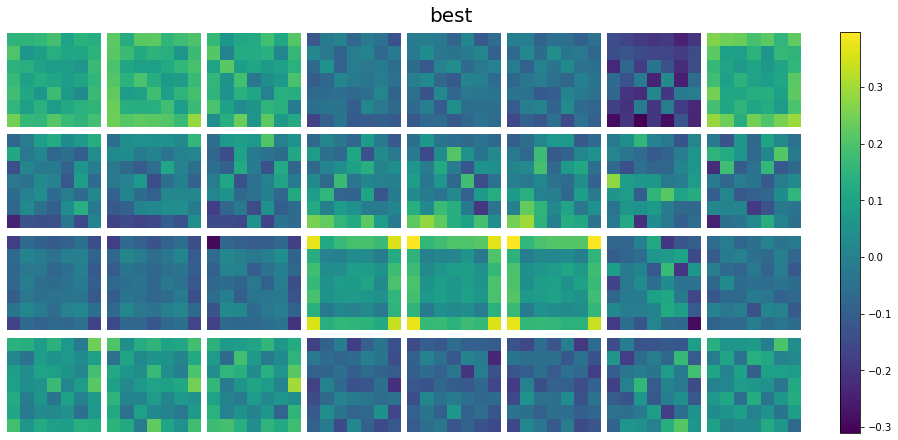

In [83]:
fig = vis_4D(data=conv_weights[3].transpose(1,0,2,3), title=ckpt_name, return_mode='plt_fig', figsize_factor=1.5, tune_factor=0.4, fontsize=20)

In [29]:
fig_dir = f'/home/wangyh/01-Projects/03-my/figures/baseline'
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, f'{ckpt_name}.png')
fig.savefig(fig_path, bbox_inches='tight')

Loading model parameters ...
best val acc is: 0.686750054359436
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.8592500686645508
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.9140000343322754
Successfully load model parameters!
Loading model parameters ...
best val acc is: 0.9337500333786011
Successfully load model parameters!


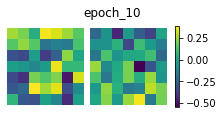

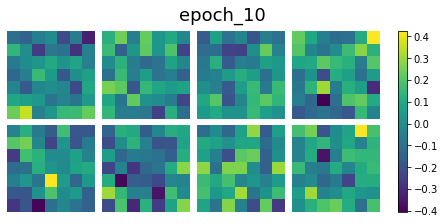

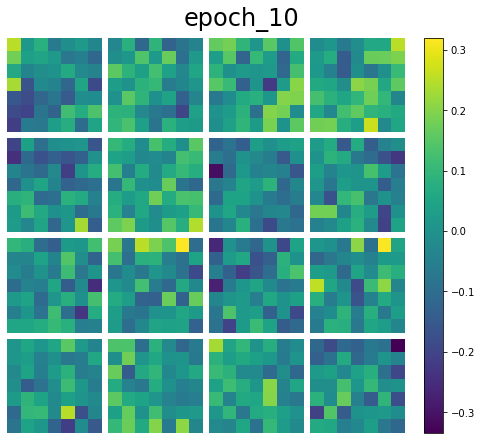

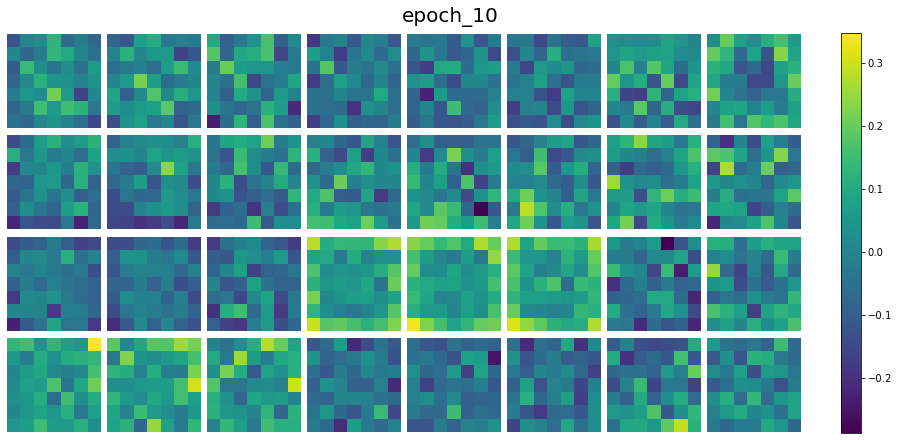

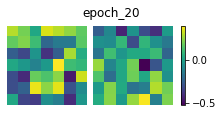

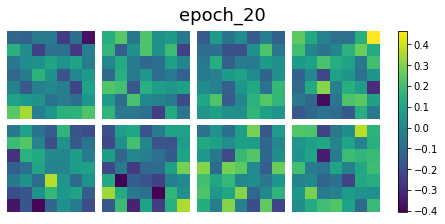

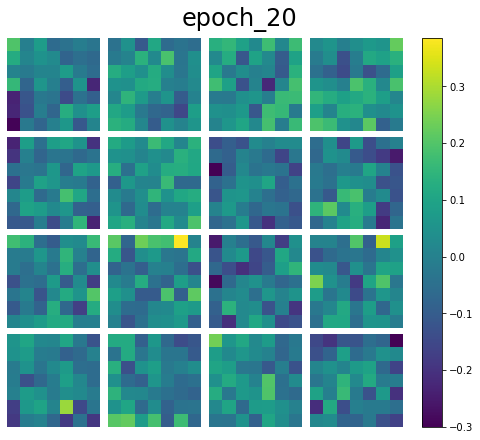

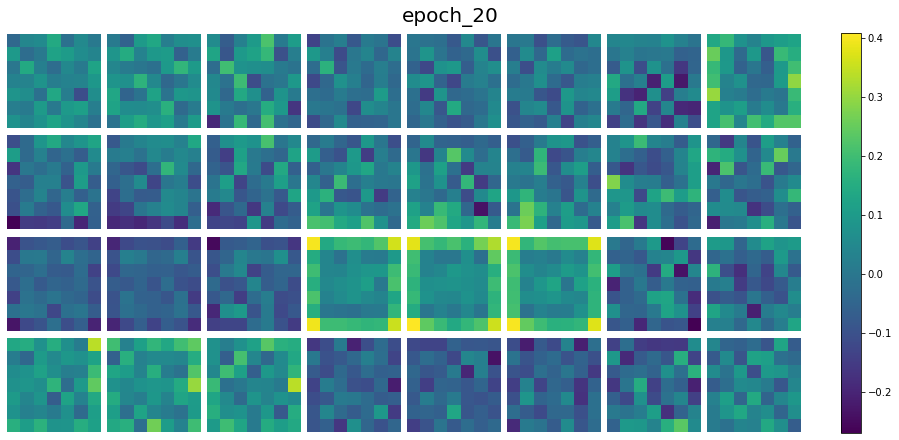

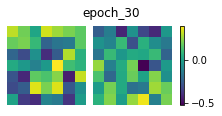

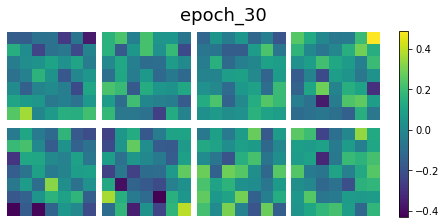

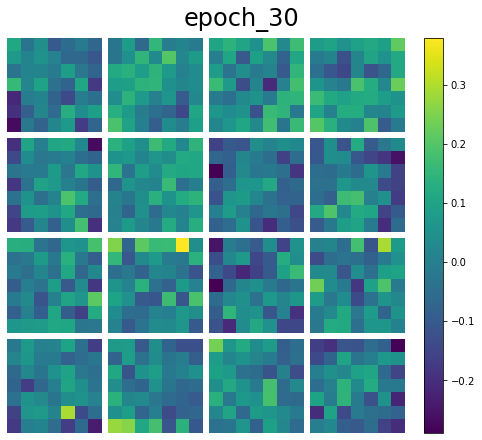

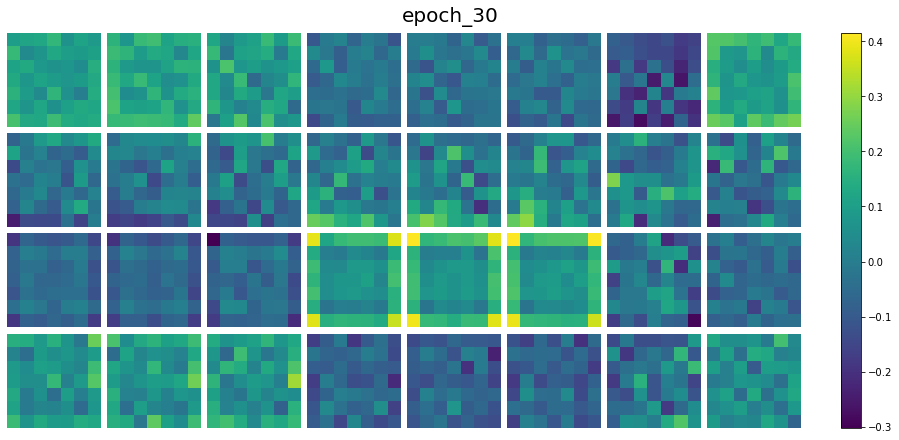

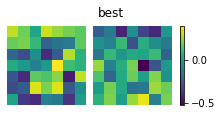

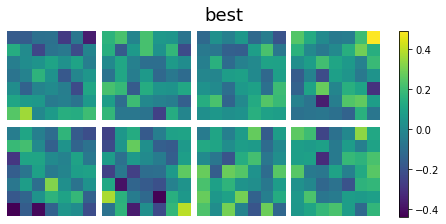

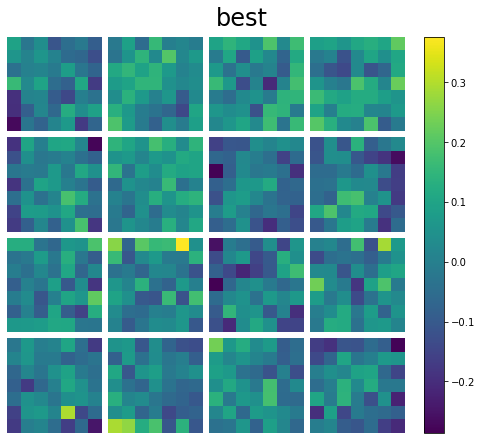

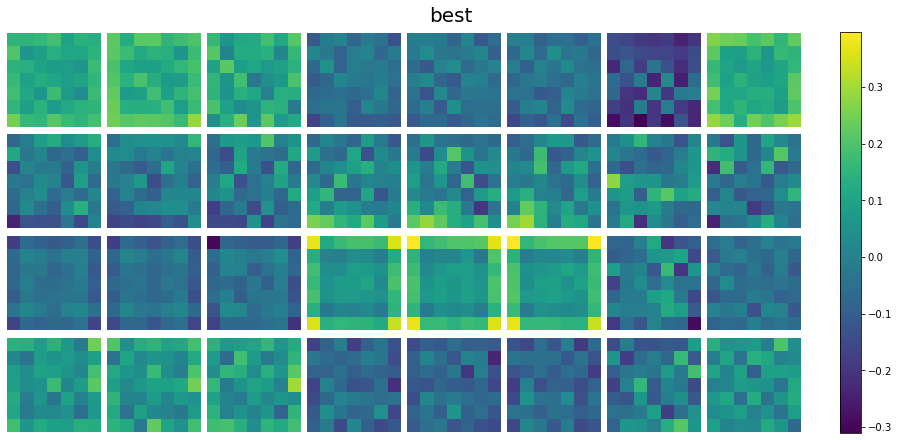

In [84]:
model_name = 'baseline'
fig_dir = os.path.join('/home/wangyh/01-Projects/03-my/figures/', model_name)
os.makedirs(fig_dir, exist_ok=True)
tune_factors = [0, 0.1, 0.6, 0.4]
fontsizes = [12, 18, 24, 20 ]
for ckpt_name in ['epoch_10', 'epoch_20', 'epoch_30', 'best']:
    model = load_model(run_name='2022_06_06_06_51_25',
                   log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                   ckpt_name=ckpt_name).to(device)
    conv_weights = get_conv_weights(model)
    for cw_idx in [0, 1, 2, 3]:
        fig = vis_4D(data=conv_weights[cw_idx].transpose(1,0,2,3), title=ckpt_name, return_mode='plt_fig',
                     figsize_factor=1.5, tune_factor=tune_factors[cw_idx], fontsize=fontsizes[cw_idx])
        fig_path = os.path.join(fig_dir, f'{ckpt_name}_cw{cw_idx}.png')
        fig.savefig(fig_path, bbox_inches='tight')


In [21]:
model = load_model(run_name='2022_05_31_22_51_30').to(device)

Loading model parameters ...
best val acc is: 0.9757500290870667
Successfully load model parameters!


In [29]:
from torch import distributed
from torch.nn.parallel import DistributedDataParallel as DDP

distributed.init_process_group(backend='nccl',
                               init_method='tcp://127.0.0.1:4250',
                               world_size=1,
                               rank=0)

model = DDP(model,
            device_ids=[0],
            output_device=0,
            find_unused_parameters=False)

RuntimeError: trying to initialize the default process group twice!

In [ ]:
model = DDP(model,
            device_ids=[0],
            output_device=0,
            find_unused_parameters=False)

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
type(model) == DDP

In [37]:
images, lables = next(iter(vis_loader))
images = images.to(device)
lables = lables.to(device)
fmaps = get_feature_maps(model.to('cuda:0'), (images, lables))

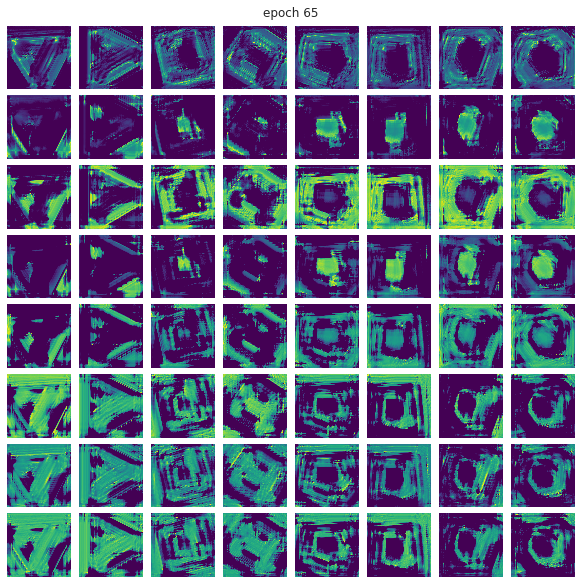

In [38]:
vis_4D(data=fmaps[3].transpose(1,0,2,3), title='epoch 65', return_mode=None, figsize_factor=1)